# Figure 2
## Global Period Maps

In [9]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import cartopy.crs as ccrs


def sig_testing(all_ds, xaer_ds):
    all_array = all_ds.values
    xaer_array = xaer_ds.values

    def welch_t_test(all_pt, xaer_pt, lat, lon):
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)

    results = []
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["year"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["year"].size, lati, loni].flatten()
            t_value, p_value = ttest_ind(all_pt, xaer_pt, equal_var=False)
            results.append(((lat, lon), p_value))

    sig_results = (all_ds.mean(dim="member").mean(dim="year").load() * 0).rename("p-value")
    for (lat, lon), p_value in results:
        sig_results.loc[dict(lat=lat, lon=lon)] = p_value
    return sig_results

client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=10>

In [7]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"

hw_mn_all = xarray.open_zarr(hw_mn_all_path)["HWF"]
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)["HWF"]

fut_start, fut_end = 2020, 2049
past_start, past_end = 1961, 1990

hw_mn_all_fut = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(fut_start, fut_end)).compute()
hw_mn_xaer_fut = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(fut_start, fut_end)).compute()
hw_mn_all_past = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(past_start, past_end)).compute()
hw_mn_xaer_past = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(past_start, past_end)).compute()

hw_mn_sig_fut = sig_testing(hw_mn_all_fut, hw_mn_xaer_fut)
hw_mn_sig_past = sig_testing(hw_mn_all_past, hw_mn_xaer_past)

hw_mn_all_fut_map = hw_mn_all_fut.mean(dim=["member", "year"])
hw_mn_xaer_fut_map = hw_mn_xaer_fut.mean(dim=["member", "year"])
hw_mn_all_past_map = hw_mn_all_past.mean(dim=["member", "year"])
hw_mn_xaer_past_map = hw_mn_xaer_past.mean(dim=["member", "year"])

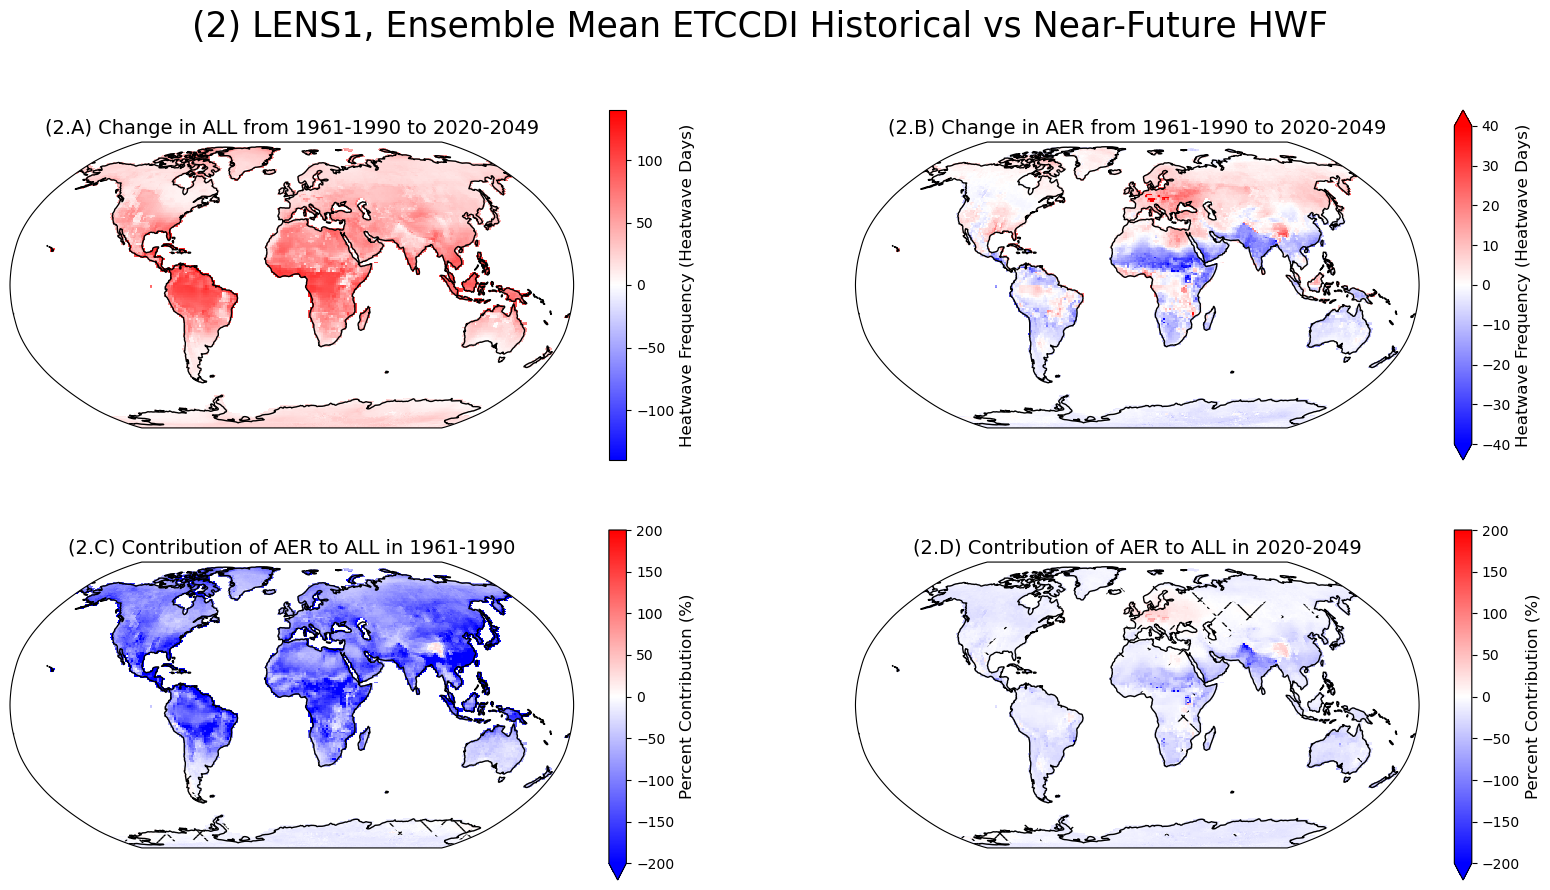

In [41]:
proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
cmap = "bwr"
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))


cb1 = (hw_mn_all_fut_map - hw_mn_all_past_map).plot(ax=ax1, transform=transform, cmap=cmap, vmax=140, vmin=-140)
cb2 = ((hw_mn_all_fut_map - hw_mn_xaer_fut_map) - (hw_mn_all_past_map - hw_mn_xaer_past_map)).plot(ax=ax2, transform=transform, cmap=cmap, vmax=40, vmin=-40)
cb3 = (100*((hw_mn_all_past_map - hw_mn_xaer_past_map) / hw_mn_all_past_map)).plot(ax=ax3, transform=transform, cmap=cmap, vmin=-200, vmax=200)
cb4 = (100*((hw_mn_all_fut_map - hw_mn_xaer_fut_map) / hw_mn_all_fut_map)).plot(ax=ax4, transform=transform, cmap=cmap, vmin=-200, vmax=200)

fz = 12
cb1.colorbar.set_label("Heatwave Frequency (Heatwave Days)", fontsize=fz)
cb2.colorbar.set_label("Heatwave Frequency (Heatwave Days)", fontsize=fz)
cb3.colorbar.set_label("Percent Contribution (%)", fontsize=fz)
cb4.colorbar.set_label("Percent Contribution (%)", fontsize=fz)

X, Y = np.meshgrid(hw_mn_sig_fut.lon, hw_mn_sig_fut.lat)
ax3.hexbin(X.reshape(-1), Y.reshape(-1), hw_mn_sig_past.where(hw_mn_sig_past > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax4.hexbin(X.reshape(-1), Y.reshape(-1), hw_mn_sig_fut.where(hw_mn_sig_fut > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

fz = 14
ax1.set_title(f"(2.A) Change in ALL from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax2.set_title(f"(2.B) Change in AER from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax3.set_title(f"(2.C) Contribution of AER to ALL in {past_start}-{past_end}", fontsize=fz)
ax4.set_title(f"(2.D) Contribution of AER to ALL in {fut_start}-{fut_end}", fontsize=fz)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

f.suptitle("(2) LENS1, Ensemble Mean ETCCDI Historical vs Near-Future HWF", fontsize=25)
f.show()

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))
